[INFO] Генерация синтетического временного ряда...
[INFO] Данные подготовлены. Размер выборки: 1000
[INFO] --- Статистические тесты ---
[INFO] ADF Statistic: -1.2352 (p-value: 0.6583)
[INFO] Shapiro-Wilk: 0.9693 (p-value: 0.0000)


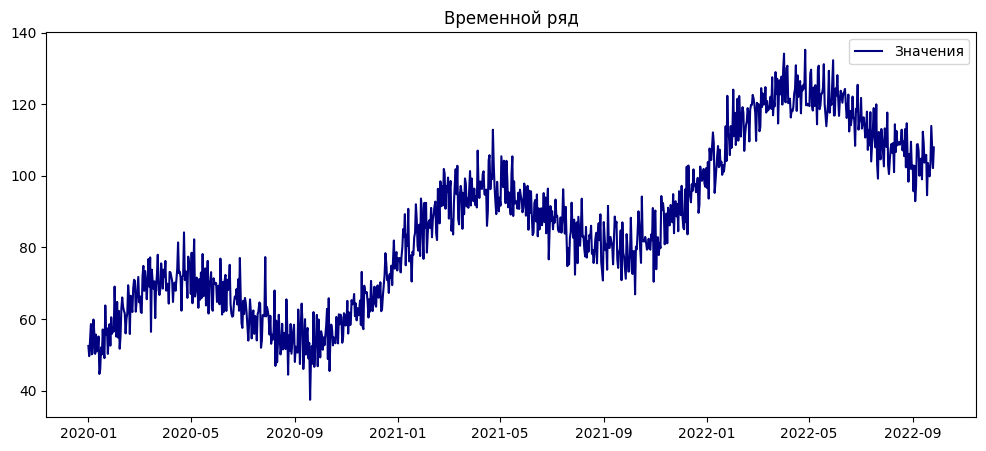

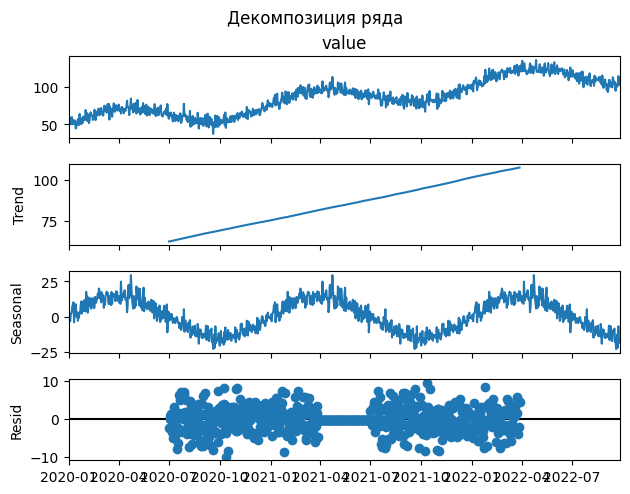

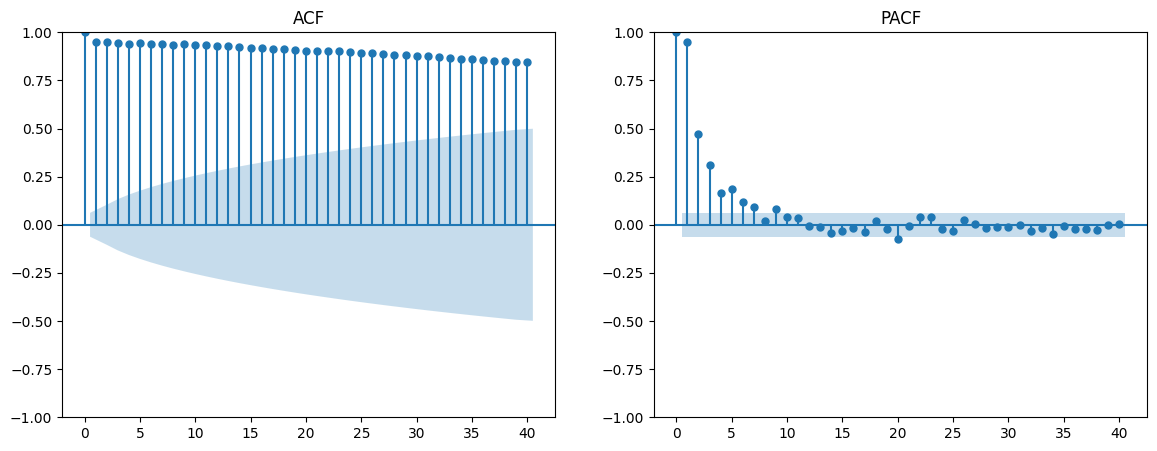

[INFO] --- Запуск SARIMAX (Grid Search) ---
[INFO] Лучшая модель SARIMA(1, 1, 1) с AIC: 6136.66
[INFO] --- Запуск LSTM ---
[INFO] Обучение LSTM завершено. Loss: 0.0047
[INFO] --- Визуализация результатов ---


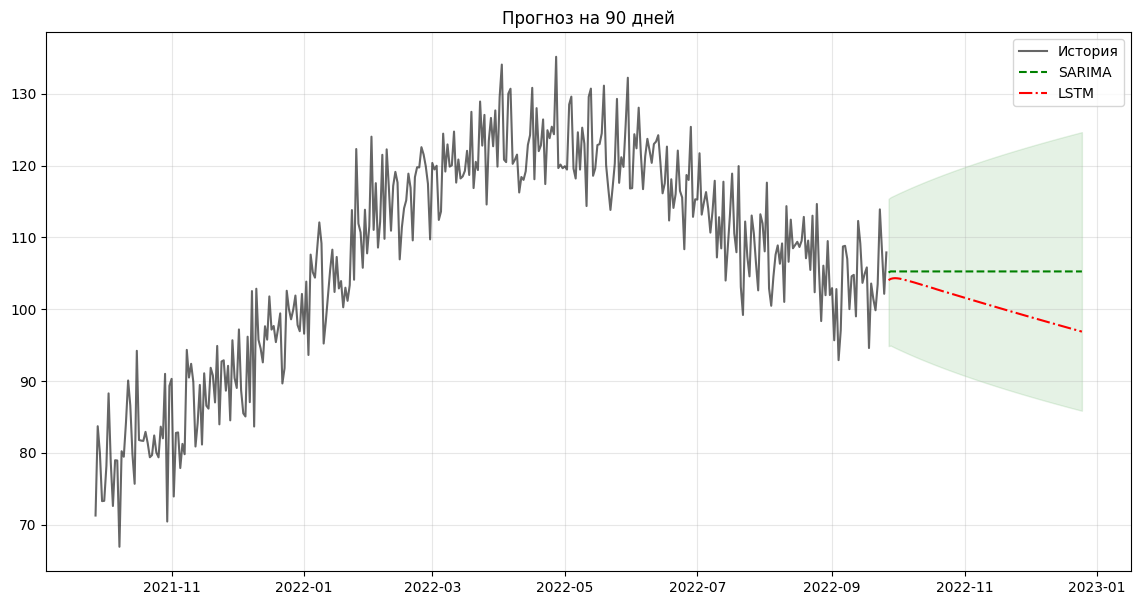

In [ ]:
import os
import sys
import itertools
import logging
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from datetime import datetime, timedelta
from math import sqrt
from typing import Tuple, Optional, Dict

from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')
logger = logging.getLogger(__name__)

class TimeSeriesAnalyst:
    def __init__(self, n_points: int = 1000, seed: int = 42, horizon: int = 90, window: int = 30):
        self.n_points = n_points
        self.seed = seed
        self.horizon = horizon
        self.window = window
        self.data: Optional[pd.DataFrame] = None
        self.scaler = MinMaxScaler()
        
        self.predictions = {}
        self.models = {}
        
        np.random.seed(seed)
        tf.random.set_seed(seed)

    def load_or_generate_data(self, filepath: str = None):
        """Лабораторная №1: Генерация или загрузка данных"""
        if filepath and os.path.exists(filepath):
            logger.info(f"Загрузка данных из {filepath}")
            df = pd.read_csv(filepath, parse_dates=['date'])
        else:
            logger.info("Генерация синтетического временного ряда...")
            start_date = datetime(2020, 1, 1)
            
            dates = pd.date_range(start=start_date, periods=self.n_points, freq='D')
            
            time_index = np.arange(self.n_points)
            noise = np.random.normal(0, 5, self.n_points)
            trend = np.linspace(50, 120, self.n_points)
            seasonality = 15 * np.sin(time_index * 2 * np.pi / 365)
            
            values = trend + seasonality + noise
            df = pd.DataFrame({"date": dates, "value": values})

        df = df.sort_values('date').set_index('date')
        if df.index.freq is None:
            df = df.asfreq('D')
        
        df = df.dropna()
        self.data = df
        logger.info(f"Данные подготовлены. Размер выборки: {len(self.data)}")

    def run_exploratory_analysis(self, show_plots: bool = True):
        """Лабораторная №1: Статистические тесты и декомпозиция"""
        series = self.data['value']
        
        logger.info("--- Статистические тесты ---")
        adf_res = adfuller(series)
        logger.info(f"ADF Statistic: {adf_res[0]:.4f} (p-value: {adf_res[1]:.4f})")
        
        stat, p = shapiro(series)
        logger.info(f"Shapiro-Wilk: {stat:.4f} (p-value: {p:.4f})")

        if not show_plots:
            return

        # Графики
        plt.figure(figsize=(12, 5))
        plt.plot(series, label='Значения', color='navy')
        plt.title("Временной ряд")
        plt.legend()
        plt.show()

        try:
            decomp = seasonal_decompose(series, model='additive', period=365)
            decomp.plot()
            plt.suptitle("Декомпозиция ряда", y=1.02)
            plt.show()
        except Exception as e:
            logger.warning(f"Не удалось построить декомпозицию: {e}")

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        plot_acf(series, lags=40, ax=axes[0], title="ACF")
        plot_pacf(series, lags=40, ax=axes[1], title="PACF")
        plt.show()

    def run_statistical_modeling(self):
        """Лабораторная №1: Моделирование SARIMAX"""
        logger.info("--- Запуск SARIMAX (Grid Search) ---")
        series = self.data['value']
        
        best_aic = float('inf')
        best_order = None
        best_model_res = None
        
        pdq_range = range(2) 
        params_list = list(itertools.product(pdq_range, pdq_range, pdq_range))
        
        for order in params_list:
            try:
                model = SARIMAX(series, 
                                order=order, 
                                seasonal_order=(0, 0, 0, 365),
                                enforce_stationarity=False, 
                                enforce_invertibility=False)
                res = model.fit(disp=False, maxiter=20)
                
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = order
                    best_model_res = res
            except:
                continue
                
        logger.info(f"Лучшая модель SARIMA{best_order} с AIC: {best_aic:.2f}")
        
        forecast_res = best_model_res.get_forecast(steps=self.horizon)
        self.predictions['SARIMA'] = {
            'mean': forecast_res.predicted_mean,
            'ci': forecast_res.conf_int()
        }
        self.models['SARIMA'] = best_model_res

    def _create_sequences(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        X, y = [], []
        for i in range(len(data) - self.window):
            X.append(data[i:(i + self.window)])
            y.append(data[i + self.window])
        return np.array(X), np.array(y)

    def run_neural_modeling(self):
        """Лабораторная №2: Моделирование LSTM"""
        logger.info("--- Запуск LSTM ---")
        
        raw_values = self.data['value'].values.reshape(-1, 1)
        scaled_data = self.scaler.fit_transform(raw_values)
        
        X, y = self._create_sequences(scaled_data.flatten())
        X = X.reshape((X.shape[0], X.shape[1], 1))
        
        split_idx = int(0.8 * len(X))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_train, y_val = y[:split_idx], y[split_idx:]
        
        model = Sequential([
            Input(shape=(self.window, 1)),
            LSTM(64, return_sequences=False),
            Dropout(0.2),
            Dense(1)
        ])
        
        model.compile(optimizer='adam', loss='mse')
        
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(
            X_train, y_train, 
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=32, 
            callbacks=[es], 
            verbose=0
        )
        logger.info(f"Обучение LSTM завершено. Loss: {history.history['loss'][-1]:.4f}")
        
        forecast_scaled = []
        current_batch = scaled_data[-self.window:].flatten()
        
        for _ in range(self.horizon):
            input_seq = current_batch.reshape((1, self.window, 1))
            pred_val = model.predict(input_seq, verbose=0)[0, 0]
            forecast_scaled.append(pred_val)
            current_batch = np.roll(current_batch, -1)
            current_batch[-1] = pred_val
            
        forecast_final = self.scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()
        self.predictions['LSTM'] = {'mean': forecast_final}

    def visualize_results(self):
        logger.info("--- Визуализация результатов ---")
        
        last_date = self.data.index[-1]
        future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=self.horizon)
        
        plt.figure(figsize=(14, 7))
        
        plot_start_idx = max(0, len(self.data) - 365)
        plt.plot(self.data.index[plot_start_idx:], self.data['value'][plot_start_idx:], 
                 label='История', color='black', alpha=0.6)
        
        if 'SARIMA' in self.predictions:
            s_pred = self.predictions['SARIMA']
            plt.plot(future_dates, s_pred['mean'], label='SARIMA', color='green', linestyle='--')
            plt.fill_between(future_dates, 
                             s_pred['ci'].iloc[:, 0], 
                             s_pred['ci'].iloc[:, 1], 
                             color='green', alpha=0.1)

        if 'LSTM' in self.predictions:
            l_pred = self.predictions['LSTM']
            plt.plot(future_dates, l_pred['mean'], label='LSTM', color='red', linestyle='-.')

        plt.title(f"Прогноз на {self.horizon} дней")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

SETTINGS = {
    'input_file': None,
    'n_samples': 1000,
    'horizon': 90,
    'window': 30,
    'show_plots': True
}

analyst = TimeSeriesAnalyst(
    n_points=SETTINGS['n_samples'], 
    horizon=SETTINGS['horizon'],
    window=SETTINGS['window']
)

analyst.load_or_generate_data(SETTINGS['input_file'])
analyst.run_exploratory_analysis(show_plots=SETTINGS['show_plots'])
analyst.run_statistical_modeling()
analyst.run_neural_modeling()
analyst.visualize_results()